## 1 — global setup: seed, imports, deterministic backend   

In [1]:
RANDOM_SEED = 42

# ── make project root importable ────────────────────────────────
import sys
import pathlib
sys.path.append(str(pathlib.Path.cwd().parent))          # …/twitter-airline-analysis

# ── stdlib ──────────────────────────────────────────────────────
import os
import random
from pathlib import Path

# ── third-party ────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt        # used for Optuna plots later
import optuna
from joblib                           import load, dump
from sklearn import set_config
from sklearn.pipeline                 import Pipeline
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.linear_model             import LogisticRegression
from sklearn.metrics                  import roc_auc_score, classification_report, RocCurveDisplay
from sklearn.model_selection          import train_test_split

# ── local project code ─────────────────────────────────────────
from twitter_airline_analysis.data_prep import load_prepared_data

# ── global sklearn setting ─────────────────────────────────────
set_config(transform_output="pandas")

# ── project paths ──────────────────────────────────────────────
PROJECT_ROOT   = Path.cwd().resolve().parent
BASELINE_PATH  = PROJECT_ROOT / "models" / "logreg_tfidf.joblib"
TUNED_MODEL_PATH = PROJECT_ROOT / "models" / "logreg_tfidf_optuna.joblib"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
ARTIFACT_DIR  = PROJECT_ROOT / "artifacts"
ARTIFACT_DIR.mkdir(exist_ok=True)

# ── reproducibility ────────────────────────────────────────────
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)

c:\Users\justi\Anaconda3\envs\twitter-sentiment-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2 - load and split data

In [2]:
def _load_series(name: str):
    """Return Series from PROCESSED_DIR/<name>.ftr (or .parquet)."""
    ftr_path = PROCESSED_DIR / f"{name}.ftr"
    pq_path  = PROCESSED_DIR / f"{name}.parquet"

    if ftr_path.exists():
        df = pd.read_feather(ftr_path)
    elif pq_path.exists():
        df = pd.read_parquet(pq_path)
    else:
        raise FileNotFoundError(
            f"Neither {ftr_path.name} nor {pq_path.name} found in {PROCESSED_DIR}"
        )

    if df.shape[1] == 1:
        return df.iloc[:, 0]                  # take the sole column, whatever its name
    elif name in df.columns:
        return df[name]                       # column matches expected name
    else:
        raise KeyError(
            f"Expected column '{name}' not found in {ftr_path.name}. "
            f"Columns present: {list(df.columns)}"
        )

# X, y splits already materialised during Module‑4
X_train = _load_series("X_train")
X_valid = _load_series("X_val")
X_test  = _load_series("X_test")

y_train = _load_series("y_train")
y_valid = _load_series("y_val")
y_test  = _load_series("y_test")

print(
    "Shapes —",
    f"train: {X_train.shape},  valid: {X_valid.shape},  test: {X_test.shape}"
)


Shapes — train: (11712,),  valid: (1464,),  test: (1464,)


## 3 - Baseline Reference (Pre‑Optuna)      

In [3]:
"""
Falls back to training a minimal model
if the file isn’t found, so the notebook remains runnable end-to-end.
"""

print(f"Looking for baseline at: {BASELINE_PATH}")

if BASELINE_PATH.exists():
    baseline_pipe = load(BASELINE_PATH)
    print("✔ Loaded baseline artefact.")
else:
    print("✗ Baseline artefact not found – training quick default model...")
    baseline_pipe = Pipeline([
        ("tfidf", TfidfVectorizer(sublinear_tf=True)),
        ("clf",   LogisticRegression(max_iter=500, n_jobs=-1, random_state=42)),
    ])
    baseline_pipe.fit(X_train, y_train)
    BASELINE_PATH.parent.mkdir(exist_ok=True)
    dump(baseline_pipe, BASELINE_PATH)
    print(f"Saved new baseline to {BASELINE_PATH}")

# ── validation metric ──────────────────────────────────────────
baseline_preds = baseline_pipe.predict_proba(X_valid)      # ← NO slicing
baseline_auc   = roc_auc_score(
    y_valid,
    baseline_preds,
    multi_class="ovr",
    average="weighted",
)


print(f"Baseline TF‑IDF + LogReg AUC (OVR, weighted): {baseline_auc:.3f}")



Looking for baseline at: C:\Projects\twitter-airline-analysis\models\logreg_tfidf.joblib
✔ Loaded baseline artefact.
Baseline TF‑IDF + LogReg AUC (OVR, weighted): 0.968


## 3 - Optuna Setup

The objective is deliberately lightweight; feature engineering is confined to TfidfVectorizer to keep search time reasonable.

In [4]:
def objective(trial: optuna.Trial) -> float:
    """Return validation ROC-AUC for a single Optuna trial."""
    # ── pipeline definition ─────────────────────────────────────
    pipeline = Pipeline([
        (
            "tfidf",
            TfidfVectorizer(
                max_df      = trial.suggest_float("max_df", 0.7, 1.0),
                min_df      = trial.suggest_int("min_df", 1, 10),
                ngram_range = (1, trial.suggest_int("max_ngram", 1, 3)),
                sublinear_tf=True,
            ),
        ),
        (
            "clf",
            LogisticRegression(
                C        = trial.suggest_loguniform("C", 1e-3, 1e2),
                penalty  = trial.suggest_categorical("penalty", ["l2", "elasticnet"]),
                solver   = "saga",
                l1_ratio = (
                    trial.suggest_float("l1_ratio", 0.0, 1.0)
                    if trial.params.get("penalty") == "elasticnet"
                    else None
                ),
                max_iter     = 500,
                n_jobs       = -1,
                random_state = RANDOM_SEED,
            ),
        ),
    ])

    pipeline.fit(X_train, y_train)
    probs  = pipeline.predict_proba(X_valid)
    score  = roc_auc_score(y_valid, probs, multi_class="ovr", average="weighted")

    # ---- persist model & store path (JSON‑friendly) ------------
    model_path = ARTIFACT_DIR / f"trial_{trial.number}_pipe.joblib"
    dump(pipeline, model_path)
    trial.set_user_attr("pipeline_path", str(model_path))     # <- string, not object
    return score

# ── create / load study ────────────────────────────────────────
study = optuna.create_study(
    direction      = "maximize",
    study_name     = "logreg_tfidf_auc",
    pruner         = optuna.pruners.MedianPruner(n_warmup_steps=10),
    storage        = f"sqlite:///{ARTIFACT_DIR/'optuna_study.db'}",
    load_if_exists = True,
)

[I 2025-08-04 00:08:14,623] Using an existing study with name 'logreg_tfidf_auc' instead of creating a new one.


## 4 - Run Study

In [5]:
study.optimize(objective, n_trials=20, show_progress_bar=True)

best_path     = Path(study.best_trial.user_attrs["pipeline_path"])
best_pipeline = load(best_path)
print(f"✅ Best pipeline loaded from {best_path}")

  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\justi\AppData\Local\Temp\ipykernel_15180\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),
Best trial: 3. Best value: 0.825719:   5%|▌         | 1/20 [00:00<00:13,  1.37it/s]C:\Users\justi\AppData\Local\Temp\ipykernel_15180\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 00:08:15,378] Trial 3 finished with value: 0.8257189390909925 and parameters: {'max_df': 0.8274770483152232, 'min_df': 8, 'max_ngram': 1, 'C': 0.037213823406135015, 'penalty': 'elasticnet', 'l1_ratio': 0.36615624536316715}. Best is trial 3 with value: 0.8257189390909925.


Best trial: 4. Best value: 0.848116:  10%|█         | 2/20 [00:02<00:20,  1.14s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_15180\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 00:08:16,800] Trial 4 finished with value: 0.8481160315540904 and parameters: {'max_df': 0.9007112356742406, 'min_df': 9, 'max_ngram': 2, 'C': 0.036455886703878046, 'penalty': 'elasticnet', 'l1_ratio': 0.138915553033095}. Best is trial 4 with value: 0.8481160315540904.


Best trial: 5. Best value: 0.88097:  15%|█▌        | 3/20 [04:23<33:58, 119.91s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_15180\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 00:12:38,039] Trial 5 finished with value: 0.8809704998517609 and parameters: {'max_df': 0.8040772220909173, 'min_df': 5, 'max_ngram': 2, 'C': 80.72609335977907, 'penalty': 'elasticnet', 'l1_ratio': 0.053764290860694786}. Best is trial 5 with value: 0.8809704998517609.


Best trial: 5. Best value: 0.88097:  20%|██        | 4/20 [04:24<19:25, 72.85s/it] C:\Users\justi\AppData\Local\Temp\ipykernel_15180\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 00:12:38,755] Trial 6 finished with value: 0.5 and parameters: {'max_df': 0.8827839580648288, 'min_df': 8, 'max_ngram': 2, 'C': 0.004702448642909703, 'penalty': 'elasticnet', 'l1_ratio': 0.6130384423895848}. Best is trial 5 with value: 0.8809704998517609.


Best trial: 7. Best value: 0.908301:  25%|██▌       | 5/20 [04:25<11:44, 47.00s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_15180\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 00:12:39,897] Trial 7 finished with value: 0.9083006666056663 and parameters: {'max_df': 0.8502179471400305, 'min_df': 3, 'max_ngram': 2, 'C': 5.101504892404102, 'penalty': 'l2'}. Best is trial 7 with value: 0.9083006666056663.


Best trial: 7. Best value: 0.908301:  30%|███       | 6/20 [04:27<07:23, 31.66s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_15180\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 00:12:41,788] Trial 8 finished with value: 0.907148923050688 and parameters: {'max_df': 0.792505745731923, 'min_df': 2, 'max_ngram': 2, 'C': 18.002020718463765, 'penalty': 'l2'}. Best is trial 7 with value: 0.9083006666056663.


Best trial: 7. Best value: 0.908301:  35%|███▌      | 7/20 [04:28<04:41, 21.62s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_15180\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 00:12:42,742] Trial 9 finished with value: 0.5878506170536839 and parameters: {'max_df': 0.8467605497393733, 'min_df': 8, 'max_ngram': 2, 'C': 0.006390228075503394, 'penalty': 'elasticnet', 'l1_ratio': 0.23677304911832475}. Best is trial 7 with value: 0.9083006666056663.


Best trial: 7. Best value: 0.908301:  40%|████      | 8/20 [04:29<03:01, 15.17s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_15180\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 00:12:44,076] Trial 10 finished with value: 0.889267947790735 and parameters: {'max_df': 0.9457704820814028, 'min_df': 10, 'max_ngram': 3, 'C': 11.178567235604065, 'penalty': 'l2'}. Best is trial 7 with value: 0.9083006666056663.


Best trial: 7. Best value: 0.908301:  45%|████▌     | 9/20 [04:30<01:58, 10.77s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_15180\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 00:12:45,184] Trial 11 finished with value: 0.8732110387747023 and parameters: {'max_df': 0.7673401483780987, 'min_df': 9, 'max_ngram': 3, 'C': 0.017509400406287068, 'penalty': 'l2'}. Best is trial 7 with value: 0.9083006666056663.


Best trial: 12. Best value: 0.910794:  50%|█████     | 10/20 [04:31<01:18,  7.84s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_15180\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 00:12:46,488] Trial 12 finished with value: 0.9107937658707393 and parameters: {'max_df': 0.75896852709378, 'min_df': 3, 'max_ngram': 3, 'C': 1.5245680869325118, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  55%|█████▌    | 11/20 [04:34<00:57,  6.39s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_15180\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 00:12:49,561] Trial 13 finished with value: 0.8989134377459684 and parameters: {'max_df': 0.7079961349812044, 'min_df': 1, 'max_ngram': 3, 'C': 0.49583204311837525, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  60%|██████    | 12/20 [04:35<00:37,  4.63s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_15180\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 00:12:50,177] Trial 14 finished with value: 0.9059194821917979 and parameters: {'max_df': 0.7266463175494071, 'min_df': 4, 'max_ngram': 1, 'C': 1.2012281417087878, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  65%|██████▌   | 13/20 [04:37<00:25,  3.67s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_15180\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 00:12:51,643] Trial 15 finished with value: 0.90895418426929 and parameters: {'max_df': 0.9625779645749888, 'min_df': 3, 'max_ngram': 3, 'C': 3.6377727030557914, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  70%|███████   | 14/20 [04:38<00:17,  2.96s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_15180\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 00:12:52,965] Trial 16 finished with value: 0.9076563983013383 and parameters: {'max_df': 0.9800516027576999, 'min_df': 6, 'max_ngram': 3, 'C': 2.131964630563712, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  75%|███████▌  | 15/20 [04:39<00:12,  2.48s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_15180\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 00:12:54,324] Trial 17 finished with value: 0.9034591793150465 and parameters: {'max_df': 0.9933669858599004, 'min_df': 3, 'max_ngram': 3, 'C': 0.31161943721435864, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  80%|████████  | 16/20 [04:42<00:10,  2.72s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_15180\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 00:12:57,605] Trial 18 finished with value: 0.8853549071999014 and parameters: {'max_df': 0.9292510830519236, 'min_df': 1, 'max_ngram': 3, 'C': 0.1389164310868725, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  85%|████████▌ | 17/20 [04:44<00:06,  2.33s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_15180\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 00:12:59,012] Trial 19 finished with value: 0.8544883434951155 and parameters: {'max_df': 0.7376036426792445, 'min_df': 6, 'max_ngram': 3, 'C': 0.001032283918759201, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  90%|█████████ | 18/20 [04:47<00:05,  2.52s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_15180\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 00:13:02,005] Trial 20 finished with value: 0.8884793171363264 and parameters: {'max_df': 0.7598750405558771, 'min_df': 4, 'max_ngram': 3, 'C': 68.83299472391637, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  95%|█████████▌| 19/20 [04:48<00:01,  1.99s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_15180\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 00:13:02,749] Trial 21 finished with value: 0.9054170809481125 and parameters: {'max_df': 0.8963038325408221, 'min_df': 3, 'max_ngram': 1, 'C': 2.2385705634518454, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794: 100%|██████████| 20/20 [04:49<00:00, 14.49s/it]

[I 2025-08-04 00:13:04,486] Trial 22 finished with value: 0.8952747155659078 and parameters: {'max_df': 0.9522601101120584, 'min_df': 5, 'max_ngram': 3, 'C': 15.31957617791939, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.
✅ Best pipeline loaded from C:\Projects\twitter-airline-analysis\artifacts\trial_12_pipe.joblib


## 4 -  Persist & reload the best model

In [7]:
# ╔══════════════════════════════════════════════════════════════╗
# ║ 4 – Persist & reload the best model                          ║
# ╚══════════════════════════════════════════════════════════════╝
# 1. Locate the file written inside the objective
best_path = Path(study.best_trial.user_attrs["pipeline_path"])
print(f"✅  Best pipeline located at {best_path}")

# 2. Load it
best_pipeline = load(best_path)

# 3. Save a canonical copy in models/ for later notebooks
TUNED_MODEL_PATH.parent.mkdir(exist_ok=True)
dump(best_pipeline, TUNED_MODEL_PATH)
print(f"🔒  Saved tuned model → {TUNED_MODEL_PATH}")

# 4. (optional sanity check)
assert hasattr(best_pipeline, "predict_proba")


✅  Best pipeline located at C:\Projects\twitter-airline-analysis\artifacts\trial_12_pipe.joblib
🔒  Saved tuned model → C:\Projects\twitter-airline-analysis\models\logreg_tfidf_optuna.joblib


## 5 - Final evaluation on the held‑out test set

              precision    recall  f1-score   support

    negative      0.819     0.950     0.879       918
     neutral      0.751     0.574     0.651       310
    positive      0.821     0.564     0.668       236

    accuracy                          0.808      1464
   macro avg      0.797     0.696     0.733      1464
weighted avg      0.805     0.808     0.797      1464

Weighted OVR ROC‑AUC: 0.913


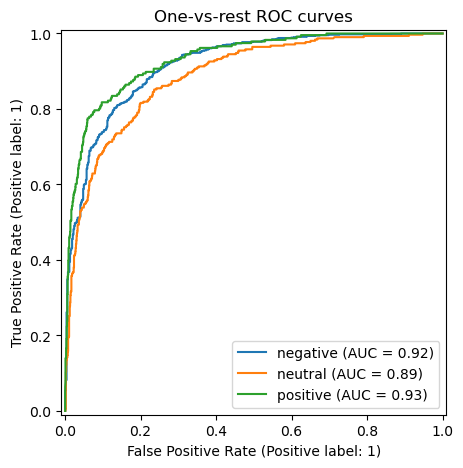

In [12]:
# ╔══════════════════════════════════════════════════════════════╗
# ║ 5 – Final evaluation on the held‑out test set                ║
# ╚══════════════════════════════════════════════════════════════╝
# 1. Discrete predictions for class‑level metrics
y_pred = best_pipeline.predict(X_test)         # → array of strings

from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay

print(classification_report(y_test, y_pred, digits=3))

# 2. Probabilities for ROC‑AUC
probs = best_pipeline.predict_proba(X_test)    # shape (n_samples, 3)

auc  = roc_auc_score(
    y_test,
    probs,
    multi_class="ovr",
    average="weighted",
)
print(f"Weighted OVR ROC‑AUC: {auc:.3f}")

# 3. Plot ROC curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(6, 5))

classes = best_pipeline.classes_           # ['negative', 'neutral', 'positive']
y_bin   = label_binarize(y_test, classes=classes)  # shape (n_samples, 3)

for i, cls in enumerate(classes):
    RocCurveDisplay.from_predictions(
        y_bin[:, i],
        probs[:, i],
        name=cls,
        ax=ax,
    )

ax.set_title("One‑vs‑rest ROC curves")
plt.show()



## 6 - Persist artefacts